# Simulación de variables aleatorias

## **Alumna: Valeria Cano Soto**

Probabilidad 1\
Semestre 2025-2\
Prof: Jorge Iván Reyes Hernández\
Facultad de Ciencias, UNAM

En este Notebook revisaremos brevemente un par de resultados que nos ayudarán a generar números aleatorios de diversas distribuciones. Comenzamos definiendo qué es una sucesión de números aleatorios uniformemente distribuidos en el intervalo $[0,1]$.

**Definición**.
Una sucesión $\{ x_n \}_{n\in \mathbb{N}^{+}}$ de números reales en el intervalo $[0,1]\subset \mathbb{R}$ es una sucesión de números aleatorios si existen
1. Un espacio de probabilidad $(\Omega, \mathcal{F}, P)$,
2. Una sucesión $\{ U_n \}_{n\in \mathbb{N}^{+}}$ de variables aleatorias independientes e idénticamente distribuidas con distribución $\mathbf{U}([0,1])$, y
3. $\omega \in \Omega$ tal que $\forall n \in \mathbb{N}^{+}$, $x_n = U_n(\omega)$.

---

Intuitivamente, podemos pensar en números aleatorios uniformemente distribuidos como las realizaciones de variables aleatorias uniformes.

Más adelante veremos que una consencuencia del _Principio fundamental de la simulación_ es que cualquier variable aleatoria puede ser simulada usando únicamente la distribución uniforme en $[0,1]$. Por lo anterior, el problema de simular variables aleatorias se reduce a saber cómo simular variables aleatorias uniformes (es decir, cómo generar números aleatorios uniformemente distribuidos en $[0,1]$).

## Un generador lineal congruencial

Un procedimiento usual para generar números (pseudo)-aleatorios es generar números enteros $y_n$ a través de la relación congruencial de recurrencia,

$$
\begin{equation}
    y_{n+1}  \equiv a y_n + b \hspace{0.5 cm} \text{mod } N
\end{equation}
$$

y luego construir la sucesión de números pseudo-aleatorios como sigue,

$$
    x_{n} = \frac{y_n}{N}, \hspace{0.5 cm} y_n \in \{0, \dots, N-1 \}
$$

donde $mcd(a, N) = 1$ (es decir, $a$ y $N$ son primos relativos). Note que por construcción, $x_n \in [0,1)$ para toda $n$, por lo que son buenos candidatos para ser números (pseudo)-aleatorios uniformemente distribuidos en $(0,1)$.

La parte fina del generador lineal congruencial es saber elegir valores de $a, b$ y $N$ adecuados. Para ver los detalles teóricos véase [1].

## Mersenne Twister + Lehmer

Por simplicidad, optaremos por hacer un generador lineal congruencial siguiendo algunas ideas del generador [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister) y del generador de [Lehmer](https://en.wikipedia.org/wiki/Lehmer_random_number_generator).

El generador Lehmer supone que $b=0$, y el generador Mersenne Twister que $N$ es un número primo de Mersenne. Además necesitamos que $mcd(y_0, N) = 1$ y que el orden multiplicativo módulo N de $a$ sea grande (aunque esto es importante para obtener el mayor periodo, no es obligatorio).

La relación congruencial de recurrencia se reduce a,

$$
\begin{equation}
    y_{n+1}  \equiv a y_n  \hspace{0.5 cm} \text{mod } N
\end{equation}
$$

con $N = 2 ^{p} - 1$ con $p$ un número primo. Al valor inicial $y_0$ se le conoce como semilla (seed, en inglés).

In [ ]:
from math import *
import matplotlib.pyplot as plt
import numpy as np
from typing import List

In [ ]:
class RandomGenerator:
    def __init__(self, seed: int, N: int = (2**43)-1, a: int = 321456,
                 b: int = 0):
        """
        :param N: Módulo. Un número primo de Mersenne. Por defecto, p = 43, N = 2^{p} - 1
        :param a: Magnitud.
        :param b: Salto. Por defecto su valor es 0 (Lehmer generator).
        :param seed: Semilla para generar el valor inicial.
        """
        # Verificamos que a y X_0 sean primos relativos con N.
        assert gcd(N, a) == 1, f"mcd({a},{N}) != 1"
        assert gcd(N, seed) == 1, f"mcd({seed},{N}) != 1"

        self.y_0: int = seed
        self.__N: int = N
        self.__a: int = a
        self.__b: int = b

    def generate(self, size: int) -> np.ndarray[float]:
        """ Genera un arreglo con self.size números pseudo-aleatorios con
            distribución uniforme.

        :param size: Tamaño de la muestra.
        """
        # Arreglo de tamaño self.size para guardar los números generados.
        U: np.ndarray = np.zeros(size, dtype=float)

        # Primer elemento y = y_1 = a * y_0 + b  mod N.
        y: int = (self.__a * self.y_0 + self.__b) % self.__N

        # Dividimos por N para asegurar que el resultado esté entre 0 y 1
        # y guardamos en el arreglo.
        U[0] = y / self.__N

        # Construimos los demás elementos recursivamente
        for i in range(1, size):
            y: float = (self.__a * y + self.__b) % self.__N
            U[i] = y / self.__N

        return U

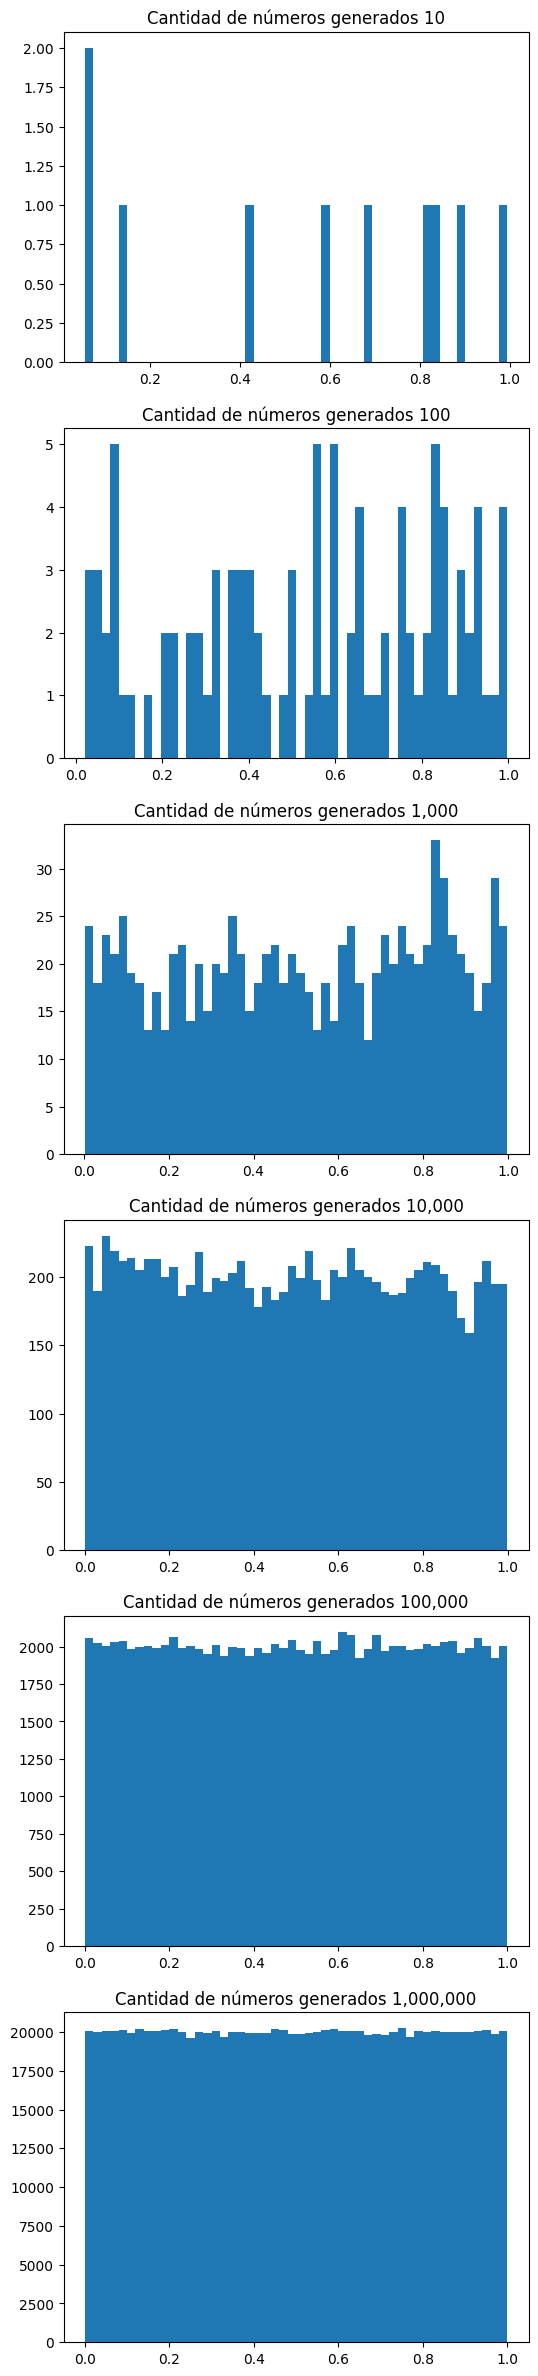

In [ ]:
# Probamos el generador

fig, ax = plt.subplots(6, 1)
fig.set_figwidth(6)
fig.set_figheight(30)

sizes: List[int] = [10 ** i for i in range(1,7)]
generator = RandomGenerator(seed=12332145654)

for i in range(len(sizes)):
    unif_custom: np.ndarray[float] = generator.generate(size=sizes[i])
    ax[i].hist(unif_custom, density=False, bins=50)
    ax[i].set_title(f'Cantidad de números generados {sizes[i]:,}')
    plt.plot()

Como podemos ver, los números generados se aproximan más a números aleatorios conforme el tamaño de la muestra crece.

__Afirmación__: El histograma aproxima bien a la función de probabilidad/densidad (en estadística 2 tienen que ver que el histograma es un estimador insesgado para la función de distribución/densidad).

## El teorema fundamental de la simulación

**Teorema (fundamental de la simulación).** Sea

$$
    X:(\Omega, \mathcal{F}, P) \to (\mathbb{R}, \mathcal{B}(\mathbb{R}), \mathbb{P}_X)
$$

una variable aleatoria. Entonces existe otra variable aleatoria

$$
    \varphi : ([0,1], \mathcal{B}([0,1]), P_{\text{Lebesgue}}) \to (\mathbb{R}, \mathcal{B}(\mathbb{R}), \mathbb{P}_{\varphi})
$$

tal que

$$
    \mathbb{P}_X = \mathbb{P}_{\varphi}  = P_{\text{Lebesgue}} \circ \varphi ^{-1}
$$

donde $P_{\text{Lebesgue}} \circ \varphi ^{-1}$ denota la imagen inversa de $\varphi$ bajo la medida de Lebesgue $P_{\text{Lebesgue}}$.

---

En otras palabras, dada una variable aleatoria con distribución $F_X (x) = \mathbb{P}_X((-\infty, x])$, siempre podemos encontrar otra variable aleatoria $\varphi$ que induzca la misma medida de probabilidad que $X$, de tal forma que sus funciones de distribución son iguales y, por tanto, para calcular $F_X$ es suficiente calcular $F_{\varphi}$

---

Lo que nos interesa del teorema anterior es el siguiente,

**Corolario (Método de inversión)** Si $U$ es una variable aleatoria con distribución uniforme en $[0,1]$ definida en el espacio de probabilidad $(\Omega, \mathcal{F}, P)$, entonces dada cualquier variable aleatoria $X$, existe una función borel-medible tal que,
$$
    X \overset{d}{=} \varphi(U)
$$
es decir
$$
  \forall x\in \mathbb{R}, F_{X}(x) = F_{\varphi(U)}(x)
$$

---

Es decir, podemos partir de números aleatorios uniformemente distribuidos en $[0,1]$, $u_i$, aplicarles una transformación apropiada, $\varphi$, y generar números aleatorios con cualquier otra distribución, $x_i = \varphi(u_i)$. Note que la elección de $\varphi$ dependerá de la distribución de $X$.

## Simulación de variables aleatorias

Ya sabemos cómo simular números pseudo-aleatorios con distribución uniforme en $[0,1]$ (véase la clase _RandomGenerator_), entonce sólo basta encontrar funciones $\varphi$ adecuadas para generar otras variables aleatorias. El ejemplo más sencillo es el de la distribución Bernoulli, $Ber(p)$.


### Distribución Bernoulli
Queremos simular números aleatorios que sigan una distribución $Ber(p)$, $p \in (0,1)$.

Para cada $p \in (0,1)$, considere $A_p = \{y \in \mathbb{R}: y \leq p \}$ y defina la función $\varphi : [0,1] \to \mathbb{R}$, dada por

$$
\begin{align*}
    \varphi(x) &= \mathbf{1}_{A_p}(x)\\
               &= \begin{cases}
                  1 &\text{ si } x \in A_p\\
                  0 &\text{ si } x \notin A_p\\
                  \end{cases}\\
               &= \begin{cases}
                  1 &\text{ si } x \leq p \\
                  0 &\text{ si } x > p \\
               \end{cases}\\
\end{align*}
$$

Entonces,

$$
\begin{align*}
    X(\omega) &= \varphi(U(\omega))\\
              &= \begin{cases}
                  1 &\text{ si } U(\omega) \leq p \\
                  0 &\text{ si } U(\omega) > p \\
               \end{cases}\\
\end{align*}
$$

Note que la variable aleatoria $X$ tiene dos resultados, $0$ y $1$, además $\mathbb{P}(X=1) = \mathbb{P}(U \leq p) = p$, por lo que $X$ tiene distribución $Ber(p)$

---

__Algoritmo__

Entrada: $n$, $p$ y $s$ (semilla del generador congruencial).

Salida: $n$ números pseudo-aleatorios con distribución $Bern(p)$.

---

- Generar $n$ números con distribución $Unif(0,1)$ usando el generador congruencial con semilla $s$:

  [$u_1, u_2, \dots, u_n$] $\leftarrow$ RandomGenerator(s).generate(n)

- Aplicar la transformación $\mathbf{1}_{A_p}$ a cada $u_i$.

  [$x_1, x_2, \dots, x_n$] $\leftarrow$ [$\mathbf{1}_{A_p}(u_1), \mathbf{1}_{A_p}(u_2), \dots, \mathbf{1}_{A_p}(u_n)$]

- Regresar [$x_1, x_2, \dots, x_n$]

---

In [ ]:
def ber(p, size, seed=96325874101):
    """ Función que simula números aleatorios con distribución Ber(p).

    :param p: Parámetro de éxito en el ensayo bernoulli.
    :para size: Tamaño de la muestra.
    :return: Arreglo con @param:size números pseudo-aleatorios con distribución ber(p)
    """

    assert 0 <= p <= 1
    assert size > 0

    # Arreglo para guardar los números aleatorios con distribución Ber(p)
    X: np.ndarray[int] = np.zeros(size, dtype=int)

    # Generamos tantos números uniformemente distribuidos como elementos bernoulli queramos
    U: np.ndarray[float] = RandomGenerator(seed=seed).generate(size=size)

    for i in range(size):
        if U[i] <= p:
            X[i] = 1
        else:
            X[i] = 0

    return X

In [ ]:
# Probamos nuestra función

ber_sample: np.ndarray[int] = ber(0.5, 120)
print(ber_sample)


[1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0
 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1
 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0
 1 0 0 1 1 0 0 1 0]


In [ ]:
# Verificamos que aproximadamente la mitad de la muestra sea 1.

cantidad_unos = sum(ber_sample)

print(cantidad_unos)

58


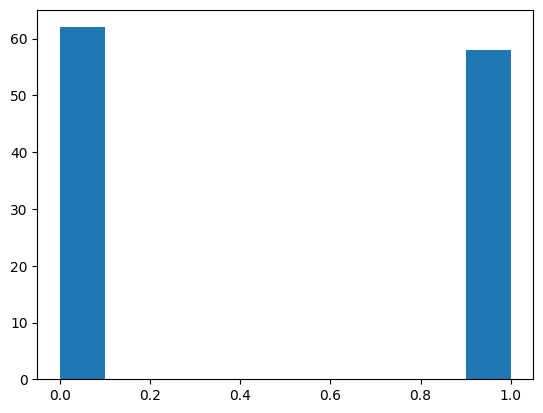

In [ ]:
# Hacemos un histograma para ver la densidad empírica de la muestra

plt.hist(ber_sample, density=False);



### Distribución Binomial
Queremos simular números aleatorios que sigan una distribución $Bin(n,p)$, $n \geq 1$, $p \in (0,1)$.

Esto es relativamente fácil de hacer, pues sabemos que si tenemos $X_1, \dots X_n \sim Ber(p)$, entonces

$$
\sum _{i=1}^{n} X_i \sim Bin(n,p)
$$

---

__Algoritmo__


Entrada: $k,$ $n$, $p$ y $s$ (semilla del generador congruencial).

Salida: $k$ números pseudo-aleatorios con distribución $Bin(n,p)$.

---

lista_binom $\leftarrow$ []

Para $i = 1$ hasta $i = k$

- Generar $n$ números pseudo-aleatorios con distribución $Bern(p)$,
  
  $b_1,\ldots,b_n$

- Hacer $x_i \leftarrow \sum_{m=1}^{n}b_i$

- Guadar $x_i$

  lista_binom[$i$] $\leftarrow x_i$

Regresar  lista_binom

---

In [ ]:
def binom(n, p, size):
    """ Función para simular números pseudo-aleatorios con distribución binom(n, p)

    :param n: Parámetro n >= 1
    :param p: Parámetro de éxito en los ensayos bernoulli.
    :param size: Tamaño de la muestra.
    :return: Arreglo con @param:size números pseudo-aleatorios con distribución binom(n,p)
    """
    assert n >= 1
    assert 0 <= p <= 1
    assert size > 0

    # Arreglo para guarda los números con distribución bin(n, p)
    Y: np.ndarray[int] = np.zeros(size, dtype=int)

    # Arreglo con semillas para generar varias muestras
    # Una semilla por muestra bernoulli
    seeds: List[int] = [123**i for i in range(size)]

    for i in range(size):
        X: np.ndarray[int] = ber(p, n, seed=seeds[i])
        Y[i] = np.sum(X)

    return Y

In [ ]:
# Probamos nuestra función
binom_sample: np.ndarray[int] = binom(16, 0.5, size=10000)

#Imprimimos primeros 10
print(binom_sample[0:10])

[10  8  9  9 11  6 10 12 10  9]


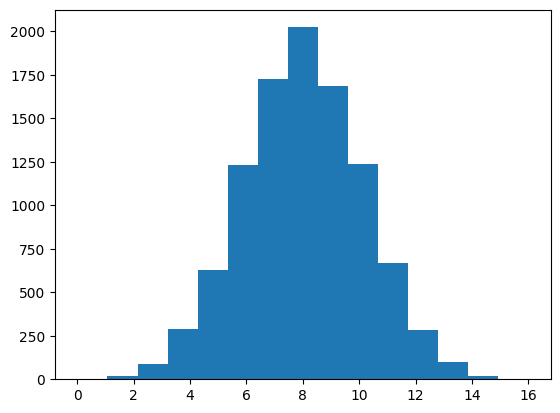

In [ ]:
plt.hist(binom_sample, density=False, bins=15);


## Práctica

---

1. Sea $U$ una variable aleatoria uniforme en $[0, 1]$. Sean $a,b \in \mathbb{R}$, $a < b$ dos constantes. Se puede demostrar que la variable aleatoria
$$
    X = \varphi(U) = a + (b-a)U
$$
tiene distribución uniforme en el intervalo $[a,b]$. Genere $n$ números pseudo-aleatorios (usando la clase _RandomGenerator_ y la función $\varphi$ adecuada) con distribución uniforme en el intervalo $[a,b]$, para $n\in\{10, 100, 1000, 10000, 100000\}$. Construya un histograma para cada una de estas muestras.

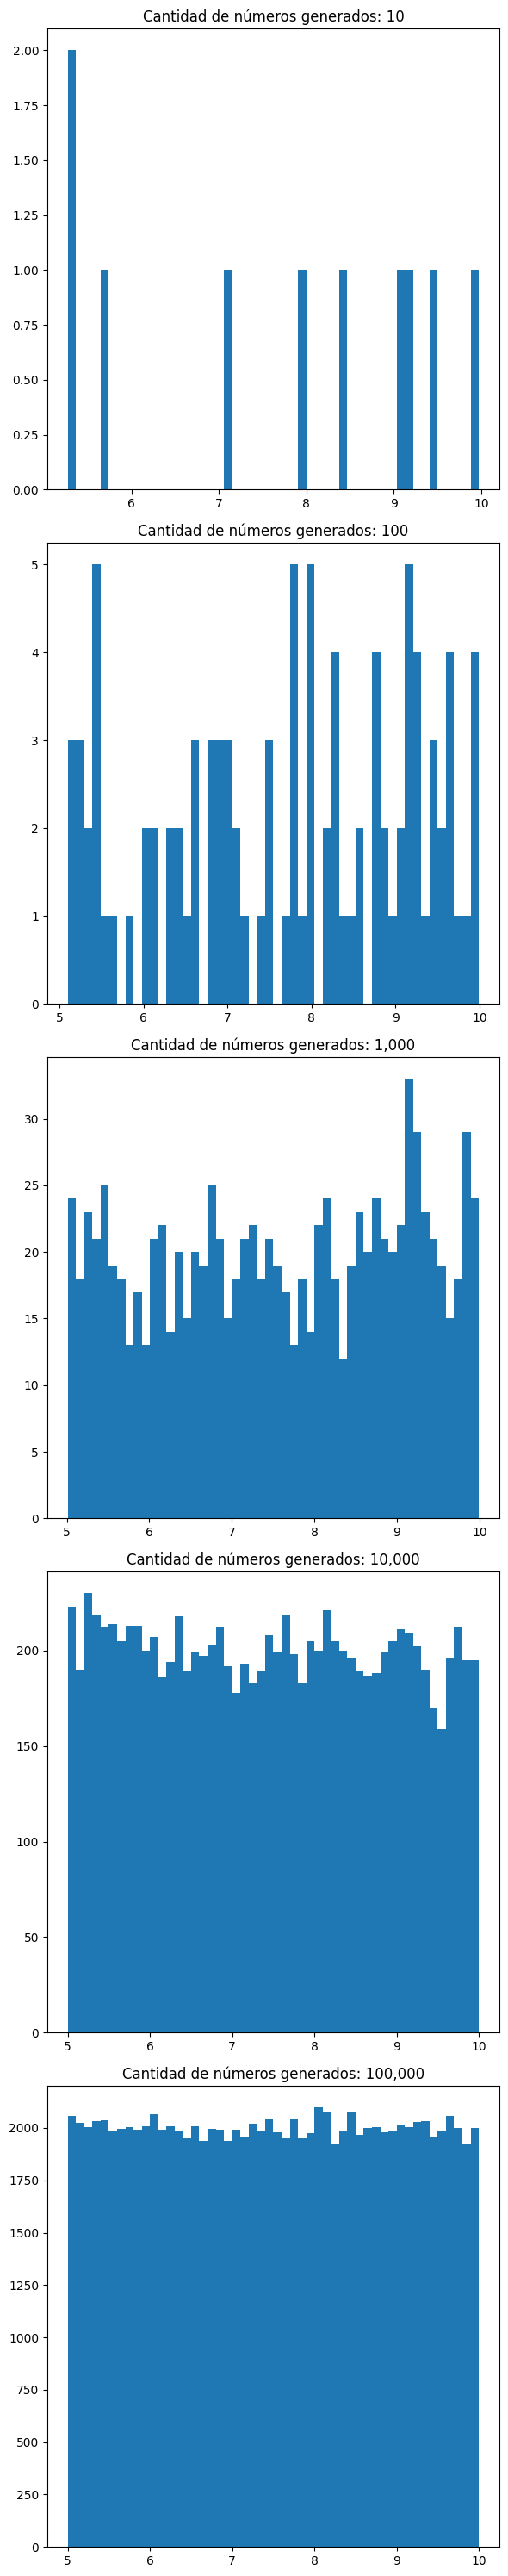

In [ ]:
# Tu solución


def unif(a, b, size, seed=12332145654):
    """ Función que simula números aleatorios con distribución Unif[a,b].

    :param a: Extremo inferior del intervalo.
    :param b: Extremo superior del intervalo.
    :para size: Tamaño de la muestra (n).
    :return: Arreglo con @param:size números pseudo-aleatorios con distribución Unif[a,b].
    """

    assert a < b

    # Arreglo para guardar los números aleatorios con distribución Unif[a,b]
    X: np.ndarray = np.zeros(size, dtype=float)

    # Generamos tantos números uniformemente distribuidos en el [0,1] como elementos uniformemente distribuidos en el [a,b] queramos
    U: np.ndarray[float] = RandomGenerator(seed=seed).generate(size=size)

    for i in range(size):
      X[i] = (b-a)*U[i] + a

    return X

fig, ax = plt.subplots(5, 1)
fig.set_figwidth(6)
fig.set_figheight(30)

sizes: List[int] = [10 ** i for i in range(1,6)]
a = 5
b = 10

for i in range(len(sizes)):
    unif_custom: np.ndarray[float] = unif(a, b, size=sizes[i])
    ax[i].hist(unif_custom, density=False, bins=50)
    ax[i].set_title(f'Cantidad de números generados: {sizes[i]:,}')

plt.tight_layout()
plt.show()

2. Sea $U$ una variable aleatoria con distribución uniforme en el intervalo $[0, 1]$. Sea $\lambda > 0$ una constante y defina la siguiente transformación,
$$
X = \varphi(U) = -\frac{1}{\lambda}\ln{(1-U)}
$$
Demuestre que $X \sim \exp(\lambda)$. Además genere $n$ números pseudo-aleatorios (usando la clase _RandomGenerator_ y la función $\varphi$ adecuada) con distribución $\exp(\lambda)$, para $n\in\{10, 100, 1000, 10000, 100000\}$. Construya un histograma para cada una de estas muestras.

---

### **Demostración.**

Sean  $U \sim Unif[0,1]$, $\lambda > 0$, $X=\varphi(U)=-\frac{1}{\lambda}\ln{(1-U)}$.

Por demostrar: $X \sim \exp(\lambda)$.

Primero, una serie de recordatorios:

1.   Si $X \sim \exp(\lambda)$, entonces, $f_X(x)=\lambda\exp(-\lambda x) \mathbf{1}_{x\geq 0}$
2.   **Teorema.** Sea $U$ una v.a. continua con soporte $Sop(U)$ y función de densidad $f_X$. Sea $\varphi: Sop(U)\subseteq\mathbb{R}\to\mathbb{R}$ una función continua, monótona y con inversa diferenciable. La función de densidad de $X=\varphi(U)$ está dada por:

$$ f_X(x) = f_U(φ^{-1}(x))\left| \frac{dφ^{-1}(x)}{dx} \right|\mathbf{1}_{φ(Sop(X))} $$

Dado que $Sop(U)=[0,1]$, se tiene que, si $u\in Sop(U)$:

$$
\begin{align*}
&\Rightarrow 0 \leq u \leq 1 \\
&\Rightarrow -1 \leq -u \leq 0 \\
&\Rightarrow 0 \leq 1-u \leq 1 \\
&\Rightarrow -\infty < \ln(1-u) \leq 0 \\
&\Rightarrow 0 \leq -\frac{1}{\lambda}\ln{(1-u)} < \infty \\
&\Rightarrow 0 \leq \varphi(u) = x < \infty \\
\end{align*}
$$

$$ \therefore Sop(X)=\varphi(Sop(U))=[0,\infty) $$

Además, obsérvese que $\varphi$ es una función monótona creciente porque, dados $u_1,u_2 \in Sop(U), u_1 < u_2:$

$$
\begin{align*}
&\Rightarrow -u_2 < -u_1 \\
&\Rightarrow 1-u_2 < 1-u_1 \\
&\Rightarrow \ln(1-u_2) < \ln(1-u_1) \\
&\Rightarrow -\frac{1}{\lambda}\ln(1-u_1) < -\frac{1}{\lambda}\ln(1-u_2)
\end{align*}
$$

$$ \therefore φ(u_1) < φ(u_2)\ \square $$

Además, $\varphi$ es continua en $[0,1)\subseteq Sop(U)$, porque es la composición de funciones continuas y en $u=1$ se indetermina. Por otro lado, si $x\in Sop(X):$

$$
\begin{align*}
&\Rightarrow x = φ(u) = -\frac{1}{\lambda}\ln(1-u),\ \text{para algún } u\in Sop(U) \\
&\Rightarrow -λx = \ln(1-u) \\
&\Rightarrow \exp(-λx) = 1-u \\
&\Rightarrow u = φ^{-1}(x) = 1 - \exp(-λx)
\end{align*}
$$


$$ \therefore φ\ \text{tiene inversa diferenciable,}\ φ^{-1}(X) = 1 - \exp(-λX). $$

De donde, podemos obtener su derivada como:

$$ \frac{dφ^{-1}(x)}{dx} = \frac{d}{dx}(1-\exp(-λx)) = -(-λ)\exp(-λx) = λ\exp(-λx) > 0,\ \forall \ x \geq 0 $$

Por lo tanto, hemos cubierto las hipótesis de teorema.

$$ \Rightarrow f_X(x) = f_U(1-\exp(-λx))\lambda\exp(-\lambda x) \mathbf{1}_{x\geq 0} = \lambda\exp(-\lambda x) \mathbf{1}_{x\geq 0},\ \text{porque} \ f_U(u) = \mathbf{1}_{[0,1]}(u) $$

$$ \therefore X \sim exp(λ) \ \blacksquare$$

Otra forma de demostrarlo, sin utilizar el teorema de manera explícita es a través de la definición de función de distribución:

$$
\begin{align*}
F_X(x) &= P(X \leq x) = P(\{ \omega \in \Omega\ |\ X(\omega) \leq x \}) \\
       &= P\left( \left\{ \omega \in \Omega\ \big| \ \varphi(U(\omega)) \leq x \right\} \right) \\
       &= P\left( \left\{ \omega \in \Omega\ \big| \ -\frac{1}{\lambda}\ln(1 - U(\omega)) \leq x \right\} \right) \\
       &= P\left( \left\{ \omega \in \Omega\ \big| \ -\lambda x \leq \ln(1 - U(\omega)) \right\} \right) \\
       &= P\left( \left\{ \omega \in \Omega\ \big| \ \exp(-\lambda x) \leq 1 - U(\omega) \right\} \right) \\
       &= P\left( \left\{ \omega \in \Omega\ \big| \ U(\omega) \leq 1 - \exp(-\lambda x) \right\} \right) \\
       &= P(U\leq 1-\exp(-λx)) \\
       &= F_U(1-\exp(-λx))
\end{align*}
$$

Luego, como $F_U$ diferenciable en $(0,1)⊆Sop(U)$:

$$
\begin{align*}
⇒f_X(x) = \frac{dF_X(x)}{dx} &= \frac{d}{dx}F_U(1-\exp(-λx)) \\
&= \frac{du}{dx}\frac{dF_U(u)}{du},\ u=1-\exp(-λx) \\
&= λ\exp(-λx)f_U(u) \\
&= λ\exp(-λx)\mathbf{1}_{[0,1]}(u) \\
&= \lambda\exp(-\lambda x) \mathbf{1}_{x\geq 0}
\end{align*}
$$

$$ \therefore  X \sim exp(λ) \ \blacksquare$$

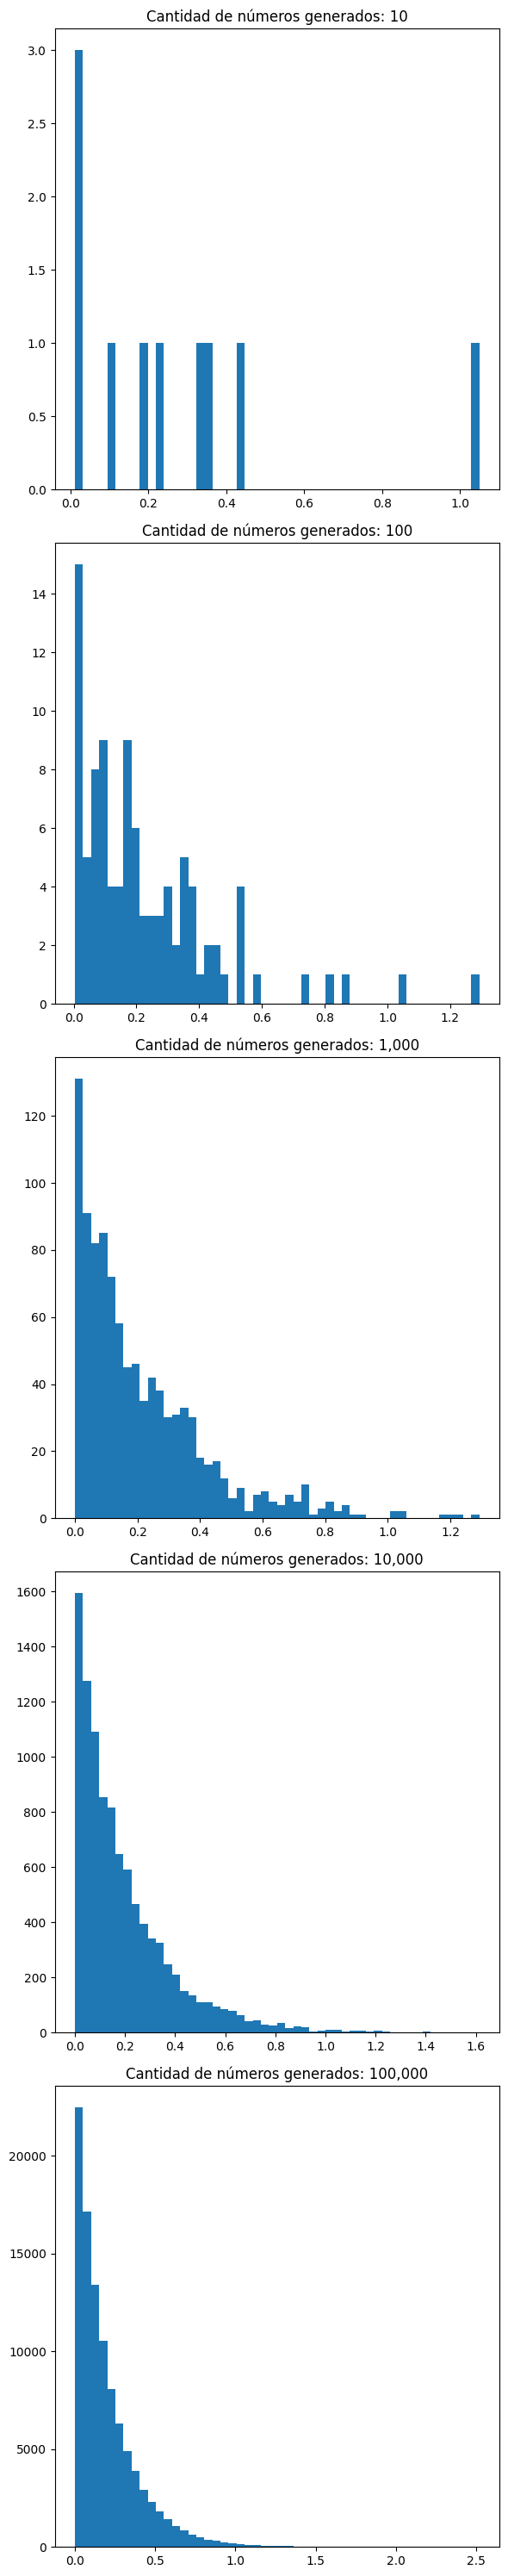

In [ ]:
# Tu solución

def exp(lam, size, seed=12332145654):
    """ Función que simula números aleatorios con distribución exp(λ).

    :param lam: Parámetro de la distribución exponencial, su recíporco puede interpretarse como el tiempo promedio de espera para que ocurra un evento.
    :para size: Tamaño de la muestra (n).
    :return: Arreglo con @param:size números pseudo-aleatorios con distribución exp(λ).
    """

    assert lam > 0

    # Arreglo para guardar los números aleatorios con distribución exp(λ)
    X: np.ndarray = np.zeros(size, dtype=float)

    # Generamos tantos números uniformemente distribuidos en el (0,1) como elementos que sigan la distribución exponencial queramos
    U: np.ndarray[float] = RandomGenerator(seed=seed).generate(size=size)

    for i in range(size):
            X[i] = -(1/lam)*log(1-U[i])

    return X

fig, ax = plt.subplots(5, 1)
fig.set_figwidth(6)
fig.set_figheight(30)

sizes: List[int] = [10 ** i for i in range(1,6)]
lam = 5

for i in range(len(sizes)):
    exp_custom: np.ndarray[float] = exp(lam,size=sizes[i])
    ax[i].hist(exp_custom, density=False, bins=50)
    ax[i].set_title(f'Cantidad de números generados: {sizes[i]:,}')

plt.tight_layout()
plt.show()

3. Uniforme discreta

Una variable aleatoria discreta $X$ sigue una distribución uniforme discreta en $\{x_1, x_2, \ldots, x_n\}$, denotado por

$$
X\sim Unif\{x_1, x_2, \ldots, x_n\}
$$

si

- $sop(X) = \{x_1, x_2, \ldots, x_n\}$
- $f_X(x) = \frac{1}{n}$

---

a) Grafique $f_X$. Haga $n=10$ y $x_i=i$ para la gráfica.

b) Genere $k\in\{10, 100, 1000, 10000, 100000\}$ números con distribución uniforme discreta en $\{x_1, x_2, \ldots, x_n\}$ usando el generador congruencial y la función $\varphi$ adecuada, y haga un histograma para cada muestra.

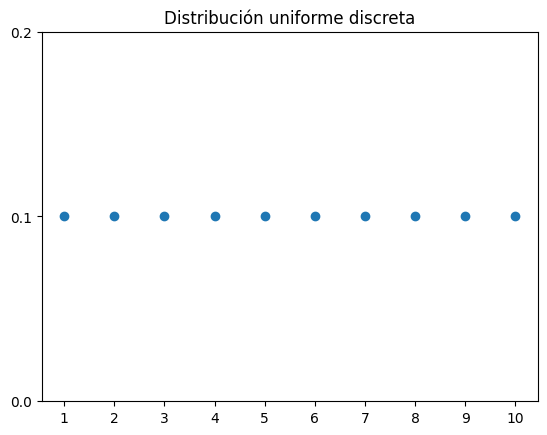

In [ ]:
# Tu solución para  a)

n = 10
x = [i for i in range(1,n+1)]
y = [1/n for i in range(1,n+1)]

plt.plot(x, y,marker='o',linestyle='None')
plt.xticks(np.arange(1, n+1, 1))
plt.yticks(np.arange(0, 0.3, 0.1))
plt.title('Distribución uniforme discreta')
plt.show()

---

Se propone la función $\varphi : [0,1] \to \mathbb{R}$, dada por:

$$
\begin{align*}
    \varphi(U(ω))
               &= \begin{cases}
                  x_1 & \ ; \ 0 \leq U(ω) < \frac{1}{n} \\
                  x_2 & \ ; \ \frac{1}{n} \leq U(ω) < \frac{2}{n} \\
                  \vdots \\
                  x_n & \ ; \ \frac{n-1}{n} \leq U(ω) < 1
                  \end{cases}
\end{align*}
$$

Veáse que en efecto $X \overset{d}{=} \varphi(U)$. Sea $i \in \{1,2,...,n \}$,

$$
\begin{align*}
    \Rightarrow f_{φ(U)}(x_i) =  P(φ(U) = x_i) &= P(\{ω\inΩ\ | \ φ(U(ω)) = x_i\}) \\
                  &= P\left(\left\{ω\inΩ\ \Big| \ \frac{i-1}{n}\leq U(ω) < \frac{i}{n}\right\}\right) \\
                  &= P\left(\frac{i-1}{n}\leq U < \frac{i}{n}\right) \\
                  &= P\left(U \leq \frac{i}{n}\right) - P\left(U \leq \frac{i-1}{n}\right) \\
                  &= F_U\left(\frac{i}{n}\right) - F_U\left(\frac{i-1}{n}\right), \text{ porque } F_U(u) = u\ \mathbf{1}_{0\leq u\leq 1} \\
                  &= \frac{i}{n} - \frac{i-1}{n} = \frac{1}{n} = f_X(x_i)
\end{align*}
$$

$$ \therefore φ(U)\text{ se distribuye como }X\ \blacksquare$$

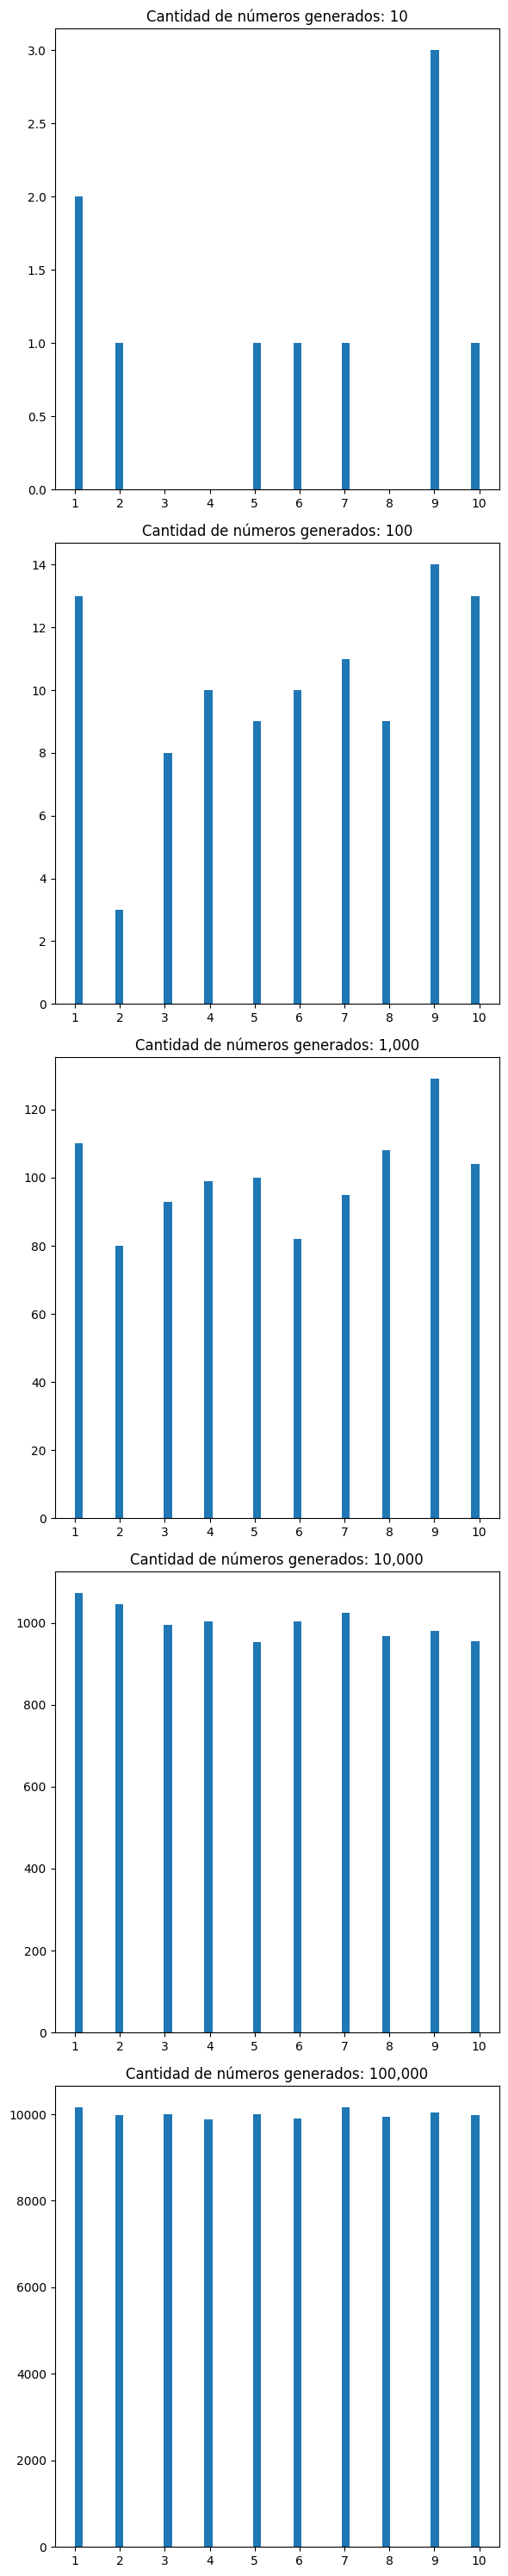

In [ ]:
# Tu solución para  b)

def unif_dis(SopX, size, seed=12332145654):
    """ Función que simula números aleatorios con distribución Unif(x_1,x_2,...,x_n).

    :param SopX: Soporte de la variable aleatoria X.
    :param size: Tamaño de la muestra (n).
    :return: Arreglo con @param:size números pseudo-aleatorios con Unif(x_1,x_2,...,x_n).
    """

    assert len(SopX) >= 1

    # Arreglo para guardar los números aleatorios con distribución Unif(x_1,x_2,...,x_n)
    X: np.ndarray = np.zeros(size, dtype=float)

    # Generamos tantos números uniformemente distribuidos en el (0,1) como elementos que sigan la distribución uniforme discreta queramos
    U: np.ndarray[float] = RandomGenerator(seed=seed).generate(size=size)

    inter = np.linspace(0, 1, len(SopX)+1) # Divide el intervalo [0,1] en len(SopX) partes iguales.

    for i in range(size):
        for j in range(len(SopX)):
            if inter[j] <= U[i] < inter[j+1]:
                X[i] = SopX[j]

    return X

fig, ax = plt.subplots(5, 1)
fig.set_figwidth(6)
fig.set_figheight(30)

sizes: List[int] = [10 ** i for i in range(1,6)]
SopX = [i for i in range(1,11)]

for i in range(len(sizes)):
    unif_dis_custom: np.ndarray[float] = unif_dis(SopX,size=sizes[i])
    ax[i].hist(unif_dis_custom, density=False, bins=50)
    ax[i].set_title(f'Cantidad de números generados: {sizes[i]:,}')
    ax[i].set_xticks(np.arange(1, n+1, 1))

plt.tight_layout()
plt.show()

4. Investiga qué transformaciones son adecuadas para generar números pseudo-aleatorios con distribución $N(0,1)$. Genera $n\in\{100, 1000, 10000, 100000\}$ números con esta distribución (usando la clase _RandomGenerator_ y las transformaciones adecuadas). Construye un histograma para cada muestra y grafícalo junto a la función de densidad correspondiente. ¿Qué tan bien se aproximan los histogramas a la función de densidad?

Hints:
- George Edward Pelham __Box__ y Mervin Edgar __Müller__ podrían ayudarte.
- El segundo problema es conocido como _Bondad de ajuste_.

---

La prupuesta para generar dichos números pseudo-aleatorios es el **Método de Box-Muller** que es una técnica para generar pares de números aleatorios independientes que siguen una distribución normal estándar (con esperanza cero y varianza igual a uno), utilizando como base una secuencia de números aleatorios con distribución uniforme.

Se asume que $U_1$ y $U_2$ son variables aleatorias independientes con distribución uniforme continua en el intervalo $(0,1]$. Entonces,

$$ Z_0 = R\cos(Θ) = \sqrt{-2\ln U_1}\cos(2\pi U_2), $$

$$ Z_1 = R\sin(Θ) = \sqrt{-2\ln U_1}\sin(2\pi U_2) $$

son variables aleatorias independientes con una distribución normal con desviación estándar 1.

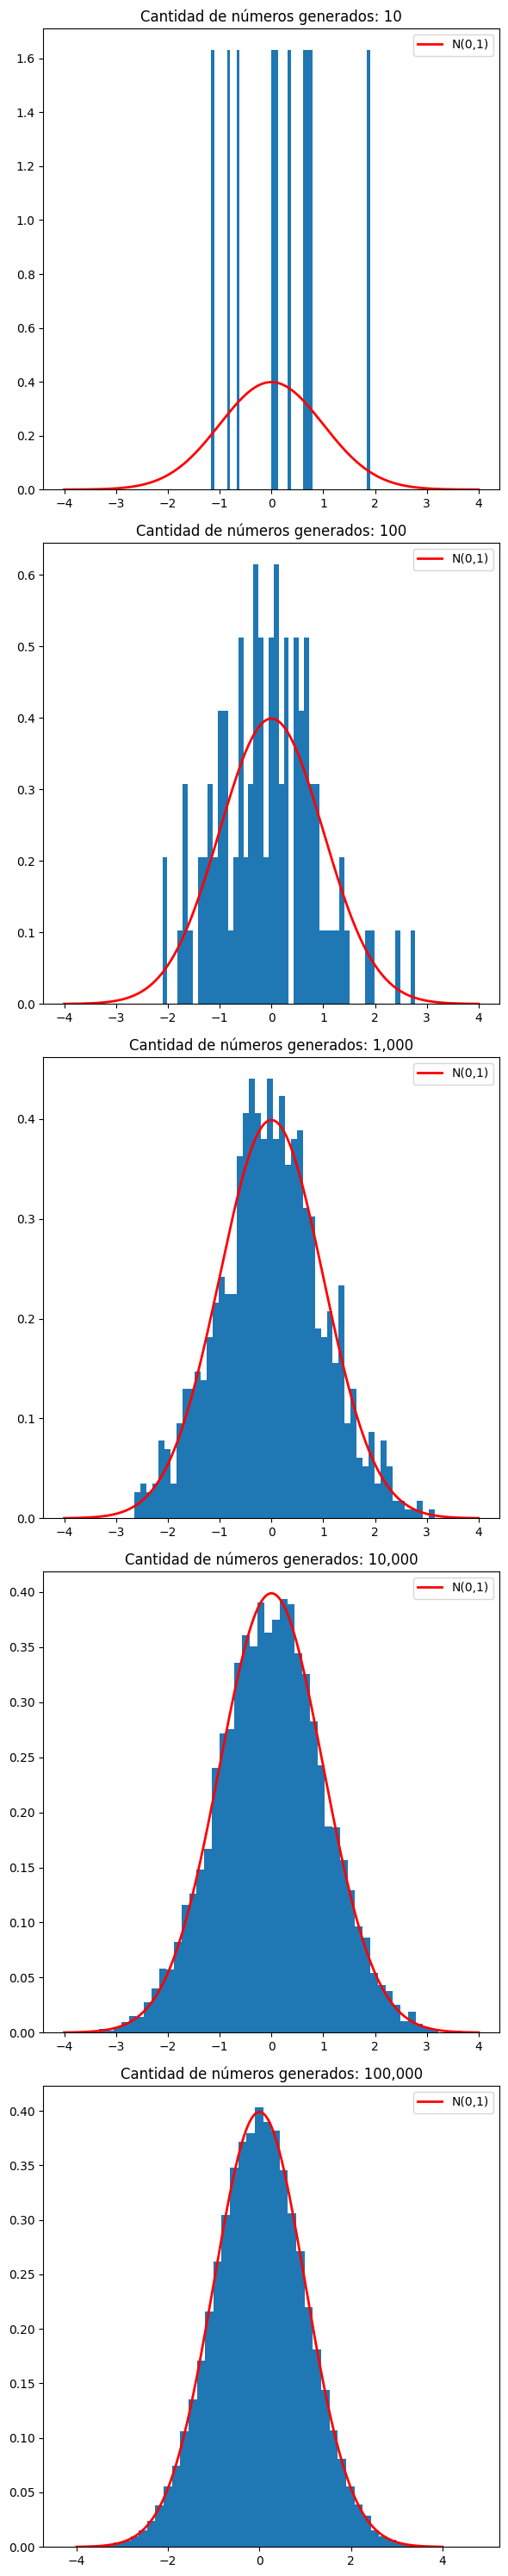

In [ ]:
# Tu solución
from scipy.stats import norm


def box_muller(size, seed=12332145654):
    """ Función que simula números pseudo-aleatorios con distribución N(0,1) utilizando el método de Box-Muller.

    :param size: Tamaño de la muestra (n).
    :return: Arreglo con @param:size números pseudo-aleatorios con distribución N(0,1) utilizando el método de Box-Muller.
    """

    assert size > 0 and size % 2 == 0 # Con esto aseguramos que el tamaño de la muestra sea par dado que por cada par de números distibuidos uniformemente, se obtiene un par de números con distribución N(0,1).

    # Arreglo para guardar los números aleatorios con distribución N(0,1)
    X: np.ndarray = np.zeros(size, dtype=float)

    # Generamos tantos números uniformemente distribuidos en el (0,1) como elementos que sigan la distribución normal queramos
    U: np.ndarray[float] = RandomGenerator(seed=seed).generate(size=size)

    for i in range(0, size, 2):
        X[i]   = np.sqrt(-2*np.log(U[i]))*np.cos(2*np.pi*U[i+1]) # Z_0
        X[i+1] = np.sqrt(-2*np.log(U[i]))*np.sin(2*np.pi*U[i+1]) # Z_1

    return X

fig, ax = plt.subplots(5, 1)
fig.set_figwidth(6)
fig.set_figheight(30)

sizes: List[int] = [10 ** i for i in range(1,6)]

for i in range(len(sizes)):
    box_muller_custom: np.ndarray[float] = box_muller(size=sizes[i])
    ax[i].hist(box_muller_custom, density=True, bins=50) # Dejamos density=True para que tenga sentido sobreponer la función de densidad teórica.
    ax[i].set_title(f'Cantidad de números generados: {sizes[i]:,}')

    x = np.linspace(-4,4,1000) # Valores del eje x para la curva
    pdf = norm.pdf(x, loc=0, scale=1) # Curva de densidad teórica
    ax[i].plot(x, pdf, 'r-', lw=2, label='N(0,1)')
    ax[i].legend()

plt.tight_layout()
plt.show()

---

A medida que aumenta el tamaño de la muestra, los histogramas generados a partir de los datos simulados se aproximan cada vez mejor a la forma de la función de densidad teórica de la distribución $N(0,1)$. Esta mejora en la aproximación se debe a la **ley de los grandes números**, que garantiza que las frecuencias relativas (representadas en el histograma) convergen a las probabilidades verdaderas conforme el número de muestras crece. Lo cual permite validar empíricamente la eficacia del método Box-Muller para la generación de números pseudo-aleatorios que siguen la distribución normal estándar.

Este fenómeno puede analizarse formalmente mediante pruebas de bondad de ajuste, como la prueba de chi-cuadrado ($χ^{2}$), la cual cuantifica qué tan cercana es la distribución empírica a una distribución teórica en específico.

---

# Referencias
[1]. Pagès, Gilles, Numerical Probability An Introduction with Applications to Finance, Springer, 2018.\
[2]. Rincón, Luis, Introducción a la probabilidad, La Prensa de Ciencias, 2014.